# BCG Argo data
Code comes from BGC-Argo Workshop: https://github.com/Flavi1P/apart_demo

In [77]:
# Loading libraries
import argopy as ar
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator
import numpy as np


Downloaded data from argo located within near the southern Icelandic shelf

In [ ]:
ds = ar.DataFetcher(src="gdac").float(4903659).to_xarray()
with ar.set_options(mode='expert'):
    ds_bgc = ar.DataFetcher(backend='erddap', ds = 'bgc').float(4903659).to_xarray()
prof = ar.ArgoFloat(4903659).open_dataset('prof')

In [79]:
display(ds)
display(ds_bgc)
display(prof)

<xarray.Dataset> Size: 2MB
Dimensions:          (N_POINTS: 13884)
Coordinates:
    TIME             (N_POINTS) datetime64[ns] 111kB 2024-05-28T10:01:58 ... ...
    LATITUDE         (N_POINTS) float64 111kB 60.0 60.0 60.0 ... 61.04 61.04
    LONGITUDE        (N_POINTS) float64 111kB -24.0 -24.0 ... -22.04 -22.04
  * N_POINTS         (N_POINTS) int64 111kB 0 1 2 3 ... 13880 13881 13882 13883
Data variables: (12/15)
    CYCLE_NUMBER     (N_POINTS) int64 111kB 1 1 1 1 1 1 1 ... 44 44 44 44 44 44
    DATA_MODE        (N_POINTS) <U1 56kB 'R' 'R' 'R' 'R' 'R' ... 'R' 'R' 'R' 'R'
    DIRECTION        (N_POINTS) <U1 56kB 'D' 'D' 'D' 'D' 'D' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_POINTS) int64 111kB 4903659 4903659 ... 4903659 4903659
    POSITION_QC      (N_POINTS) int64 111kB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    PRES             (N_POINTS) float32 56kB 1.5 2.5 3.6 ... 1.925e+03 1.961e+03
    ...               ...
    PSAL_ERROR       (N_POINTS) float32 56kB nan nan nan nan ... nan nan nan nan
    PSAL_QC          (N_POINTS) int64 111kB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TEMP             (N_POINTS) float32 56kB 9.729 9.731 9.723 ... 2.978 2.853
    TEMP_ERROR       (N_POINTS) float32 56kB nan nan nan nan ... nan nan nan nan
    TEMP_QC          (N_POINTS) int64 111kB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TIME_QC          (N_POINTS) int64 111kB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_by:           davidlewis
    Fetched_constraints:  WMO4903659
    Fetched_date:         2025/10/02
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_uri:          https://data-argo.ifremer.fr/dac/coriolis/4903659/4...
    Processing_history:   Transformed with 'profile2point'; URI merged with '...
    raw_attrs:            {'title': 'Argo float vertical profile', 'instituti...

<xarray.Dataset> Size: 40MB
Dimensions:                            (N_POINTS: 75922)
Coordinates:
    LATITUDE                           (N_POINTS) float64 607kB ...
    LONGITUDE                          (N_POINTS) float64 607kB ...
    TIME                               (N_POINTS) datetime64[ns] 607kB ...
  * N_POINTS                           (N_POINTS) int64 607kB 0 1 ... 75921
Data variables: (12/90)
    BBP700                             (N_POINTS) float32 304kB ...
    BBP700_ADJUSTED                    (N_POINTS) float32 304kB ...
    BBP700_ADJUSTED_ERROR              (N_POINTS) float32 304kB ...
    BBP700_ADJUSTED_QC                 (N_POINTS) int64 607kB 1 1 1 1 ... 1 0 1
    BBP700_DATA_MODE                   (N_POINTS) <U1 304kB 'A' 'A' ... 'A' 'A'
    BBP700_QC                          (N_POINTS) int64 607kB 1 1 1 1 ... 1 0 1
    ...                                 ...
    TEMP_ADJUSTED                      (N_POINTS) float32 304kB ...
    TEMP_ADJUSTED_ERROR                (N_POINTS) float32 304kB ...
    TEMP_ADJUSTED_QC                   (N_POINTS) int64 607kB 0 0 0 0 ... 8 1 8
    TEMP_DATA_MODE                     (N_POINTS) <U1 304kB 'R' 'R' ... 'R' 'R'
    TEMP_QC                            (N_POINTS) int64 607kB 8 8 8 8 ... 8 1 8
    TIME_QC                            (N_POINTS) int64 607kB 1 1 1 1 ... 1 1 1
Attributes:
    DATA_ID:              ARGO-BGC
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           davidlewis
    Fetched_date:         2025/10/02
    Fetched_constraints:  WMO4903659
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...

<xarray.Dataset> Size: 10MB
Dimensions:                       (N_PROF: 68, N_PARAM: 3, N_LEVELS: 1555,
                                   N_CALIB: 1, N_HISTORY: 0)
Dimensions without coordinates: N_PROF, N_PARAM, N_LEVELS, N_CALIB, N_HISTORY
Data variables: (12/64)
    DATA_TYPE                     <U16 64B ...
    FORMAT_VERSION                <U4 16B ...
    HANDBOOK_VERSION              <U4 16B ...
    REFERENCE_DATE_TIME           datetime64[ns] 8B ...
    DATE_CREATION                 datetime64[ns] 8B ...
    DATE_UPDATE                   datetime64[ns] 8B ...
    ...                            ...
    HISTORY_ACTION                (N_HISTORY, N_PROF) <U1 0B ...
    HISTORY_PARAMETER             (N_HISTORY, N_PROF) <U1 0B ...
    HISTORY_START_PRES            (N_HISTORY, N_PROF) float32 0B ...
    HISTORY_STOP_PRES             (N_HISTORY, N_PROF) float32 0B ...
    HISTORY_PREVIOUS_VALUE        (N_HISTORY, N_PROF) float32 0B ...
    HISTORY_QCTEST                (N_HISTORY, N_PROF) <U1 0B ...
Attributes:
    title:                Argo float vertical profile
    institution:          FR GDAC
    source:               Argo float
    history:              2025-06-10T16:49:15Z creation
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  3.1
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile

## Float Trajectory

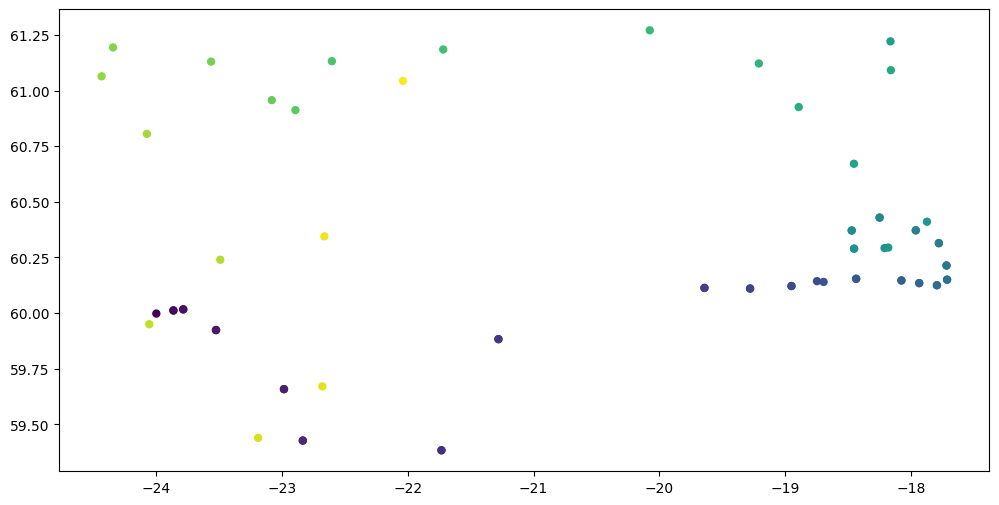

In [80]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(prof['LONGITUDE'].values, prof['LATITUDE'].values,c = prof['CYCLE_NUMBER'], s=25)
plt.show()

In [81]:
def plot_transect(ds, varname = 'CHLA_ADJUSTED', depth_min = 0, depth_max = 500, log_scale=False):
    # Build dataset from point-form arrays
    ds_points = xr.Dataset(
        {
            "VAR": ("obs", ds[varname].values),
            "PRES": ("obs", ds['PRES'].values),
            "TIME": ("obs", ds['TIME'].values)
        }
    )

    # Unique profile times
    times_unique = np.unique(ds_points['TIME'].values)

    # Regular pressure grid
    depth_grid = np.arange(depth_min, depth_max, 2)  # adjust range and step as needed

    profiles = []
    for t in times_unique:
        # Select all measurements at this time
        mask_time = ds_points['TIME'].values == t
        pres_vals = ds_points['PRES'].values[mask_time]
        var_vals = ds_points['VAR'].values[mask_time]
        
        # Drop NaNs before interpolation
        mask_valid = np.isfinite(pres_vals) & np.isfinite(var_vals)
        if mask_valid.sum() > 1:
            var_interp = np.interp(depth_grid, pres_vals[mask_valid], var_vals[mask_valid],
                                    left=np.nan, right=np.nan)
        else:
            var_interp = np.full_like(depth_grid, np.nan, dtype=float)
        profiles.append(var_interp)

    # Convert to xarray DataArray for plotting
    var_section = xr.DataArray(
        np.array(profiles),
        coords={"TIME": times_unique, "PRES": depth_grid},
        dims=("TIME", "PRES")
    )
    units = ds[varname].attrs['units']

    # Plot section
    plt.figure(figsize=(12, 6))
    if log_scale:
        pcm = plt.pcolormesh(
        var_section['TIME'],
        var_section['PRES'],
        var_section.T,
        shading='auto',
        cmap='viridis',
        norm=LogNorm(vmin=1e-3, vmax=np.nanmax(var_section))  # adjust vmin as needed
    )
    else:
        pcm = plt.pcolormesh(var_section['TIME'], var_section['PRES'], var_section.T,
                            shading='auto', cmap='viridis')
    plt.gca().invert_yaxis()
    plt.colorbar(pcm, label=f'{varname} {units}')
    plt.xlabel('Time')
    plt.ylabel('Pressure (dbar)')
    plt.title(f'BGC-Argo {varname} Section (Depth vs Time)')
    plt.tight_layout()
    plt.show()

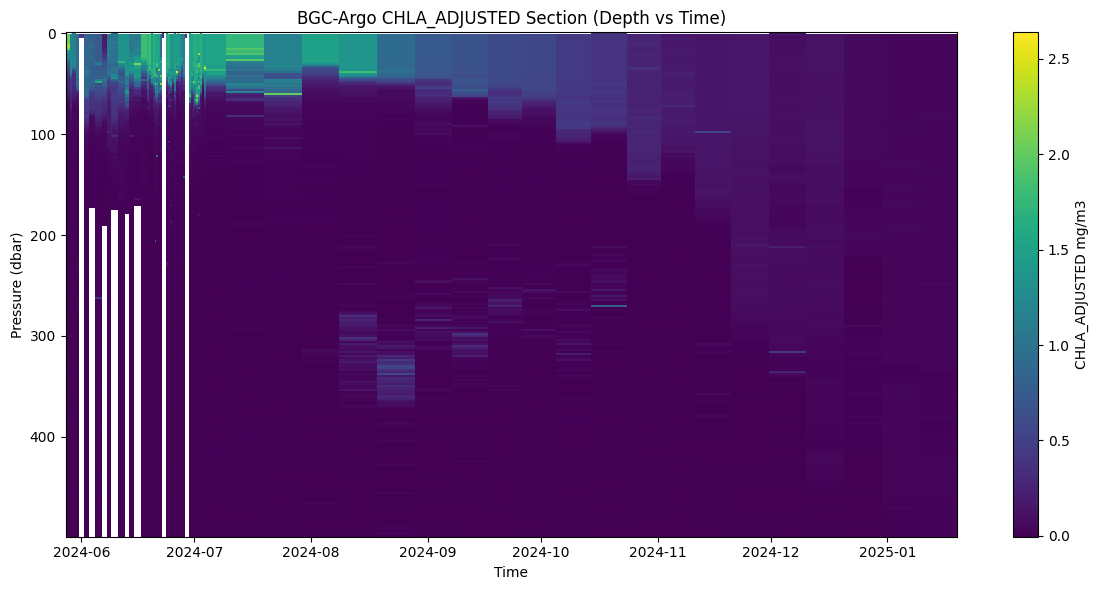

In [82]:
plot_transect(ds_bgc, 'CHLA_ADJUSTED', depth_max = 500, log_scale=False)

In [83]:

def plot_interpolated_section(ds_bgc, varname='CHLA_ADJUSTED', depth_min=0, depth_max=500, log_scale=True):
    # Build dataset from point-form arrays
    ds_points = xr.Dataset(
        {
            "VAR": ("obs", ds_bgc[varname].values),
            "PRES": ("obs", ds_bgc['PRES'].values),
            "TIME": ("obs", ds_bgc['TIME'].values)
        }
    )

    # Unique profile times
    times_unique = np.unique(ds_points['TIME'].values)

    # Regular pressure grid
    depth_grid = np.arange(depth_min, depth_max + 1, 1)  # include depth_max

    profiles = []
    for t in times_unique:
        mask_time = ds_points['TIME'].values == t
        pres_vals = ds_points['PRES'].values[mask_time]
        var_vals = ds_points['VAR'].values[mask_time]

        # Valid mask
        mask_valid = np.isfinite(pres_vals) & np.isfinite(var_vals)
        if mask_valid.sum() > 1:
            var_interp = np.interp(depth_grid, pres_vals[mask_valid], var_vals[mask_valid],
                                   left=np.nan, right=np.nan)
        else:
            var_interp = np.full_like(depth_grid, np.nan, dtype=float)
        profiles.append(var_interp)

    # Create DataArray for gridded section
    var_section = xr.DataArray(
        np.array(profiles),
        coords={"TIME": times_unique, "PRES": depth_grid},
        dims=("TIME", "PRES")
    )

    # Interpolate in time for smoothness
    time_fine = np.linspace(
        np.min(times_unique.astype("datetime64[s]").astype(float)),
        np.max(times_unique.astype("datetime64[s]").astype(float)),
        500
    ).astype("datetime64[s]")

    var_section_smooth = var_section.interp(TIME=time_fine)

    # Plotting
    plt.figure(figsize=(14, 6))

    if log_scale:
        vmin = np.nanmax([1e-6, np.nanmin(var_section_smooth.values[var_section_smooth.values > 0])])
        vmax = np.nanmax(var_section_smooth.values)
        norm = LogNorm(vmin=vmin, vmax=vmax)
        pcm = plt.pcolormesh(
            var_section_smooth['TIME'],
            var_section_smooth['PRES'],
            var_section_smooth.T,
            shading='auto',
            cmap='viridis',
            norm=norm
        )
        cbar = plt.colorbar(pcm, label=f'{varname} (log scale)')
        cbar.ax.yaxis.set_major_locator(LogLocator(base=10, subs=(1, 2, 5)))
    else:
        pcm = plt.pcolormesh(
            var_section_smooth['TIME'],
            var_section_smooth['PRES'],
            var_section_smooth.T,
            shading='auto',
            cmap='viridis'
        )
        plt.colorbar(pcm, label=varname)

    plt.gca().invert_yaxis()
    plt.xlabel('Time')
    plt.ylabel('Pressure (dbar)')
    plt.title(f'Interpolated BGC-Argo {varname} Section (Depth vs Time)')
    plt.tight_layout()
    plt.show()


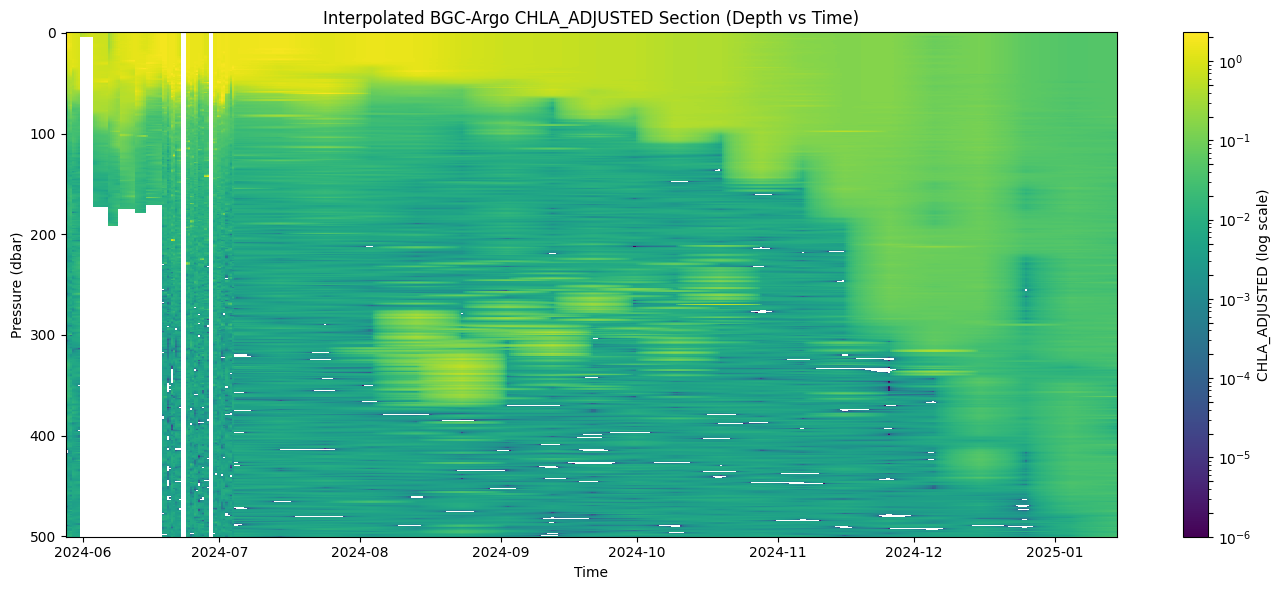

In [84]:
plot_interpolated_section(ds_bgc, 'CHLA_ADJUSTED', depth_max=500, log_scale=True)

## Depth Sepcific 

In [85]:
#Selecting Specific depths
chl_surface = ds_bgc.where(   
    (ds_bgc['PRES'] >= 0) & (ds_bgc['PRES'] <= 10))
chl_10_20 = ds_bgc.where(   
    (ds_bgc['PRES'] >= 10) & (ds_bgc['PRES'] <= 20))
chl_20_30 = ds_bgc.where(   
    (ds_bgc['PRES'] >= 20) & (ds_bgc['PRES'] <= 40))
chl_40_100 = ds_bgc.where(   
    (ds_bgc['PRES'] >= 40) & (ds_bgc['PRES'] <= 100))
chl_100_300 = ds_bgc.where(   
    (ds_bgc['PRES'] >= 100) & (ds_bgc['PRES'] <= 300))
chl_300_500 = ds_bgc.where(   
    (ds_bgc['PRES'] >= 300) & (ds_bgc['PRES'] <= 500))

# Group by profile TIME and average across the points in that depth range
chl_surface = chl_surface.groupby(ds_bgc['TIME']).mean(skipna=True)
chl_10_20 = chl_10_20.groupby(ds_bgc['TIME']).mean(skipna=True)
chl_20_30 = chl_20_30.groupby(ds_bgc['TIME']).mean(skipna=True)
chl_40_100 = chl_40_100.groupby(ds_bgc['TIME']).mean(skipna=True)
chl_100_300 = chl_100_300.groupby(ds_bgc['TIME']).mean(skipna=True)
chl_300_500 = chl_300_500.groupby(ds_bgc['TIME']).mean(skipna=True)   

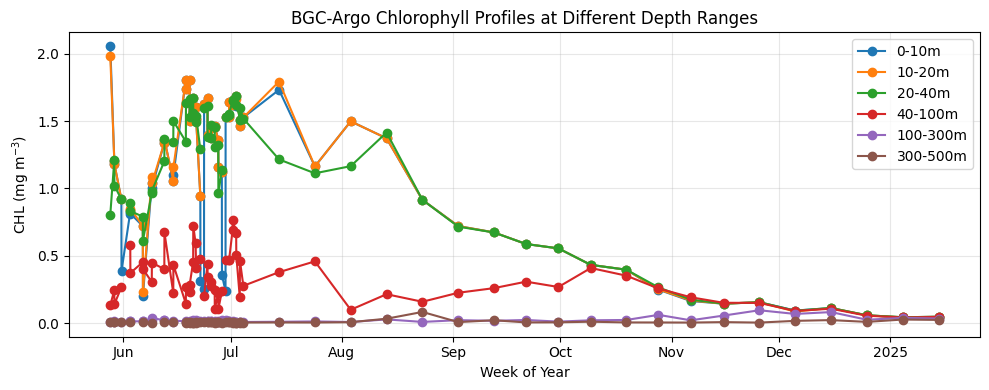

In [86]:
fig, ax = plt.subplots(figsize=(10,4))
chl_surface['CHLA_ADJUSTED'].plot(ax=ax, marker='o', label='0-10m')
chl_10_20['CHLA_ADJUSTED'].plot(ax=ax, marker='o', label='10-20m') 
chl_20_30['CHLA_ADJUSTED'].plot(ax=ax, marker='o', label='20-40m')
chl_40_100['CHLA_ADJUSTED'].plot(ax=ax, marker='o', label='40-100m')
chl_100_300['CHLA_ADJUSTED'].plot(ax=ax, marker='o', label='100-300m')
chl_300_500['CHLA_ADJUSTED'].plot(ax=ax, marker='o', label='300-500m')


ax.set_title('BGC-Argo Chlorophyll Profiles at Different Depth Ranges')
ax.set_xlabel('Week of Year')
ax.set_ylabel('CHL (mg m$^{-3}$)')


ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


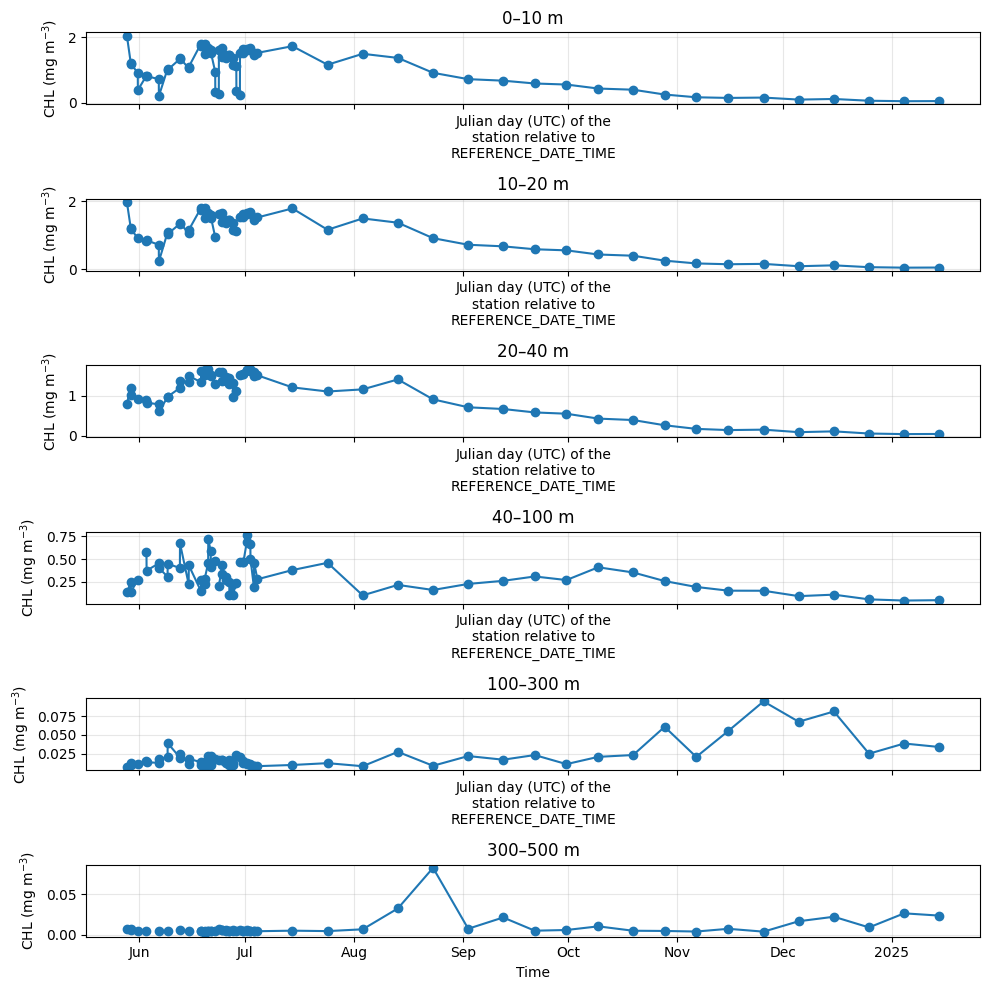

In [87]:
depth_series = {
    "0–10 m": chl_surface['CHLA_ADJUSTED'],
    "10–20 m": chl_10_20['CHLA_ADJUSTED'],
    "20–40 m": chl_20_30['CHLA_ADJUSTED'],
    "40–100 m": chl_40_100['CHLA_ADJUSTED'],
    "100–300 m": chl_100_300['CHLA_ADJUSTED'],
    "300–500 m": chl_300_500['CHLA_ADJUSTED'],
}

fig, axes = plt.subplots(len(depth_series), 1, figsize=(10, 10), sharex=True)

for ax, (label, series) in zip(axes, depth_series.items()):
    series.plot(ax=ax, marker='o')
    ax.set_title(label)
    ax.set_ylabel("CHL (mg m$^{-3}$)")
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

In [88]:
def depth_means(ds, variable="CHLA_ADJUSTED", ranges=None):
    if ranges is None:
        ranges = {"0-10": (0, 10), "10-20": (10, 20), "20-40": (20, 40), "40-100": (40, 100), "100-200": (100, 200)}
    out = {}
    for label, (lo, hi) in ranges.items():
        sel = ds.where((ds["PRES"] >= lo) & (ds["PRES"] <= hi))
        out[label] = sel.groupby(ds["TIME"]).mean(skipna=True)[variable]
    return out


In [89]:
chl_surface

<xarray.Dataset> Size: 30kB
Dimensions:                            (TIME: 68)
Coordinates:
  * TIME                               (TIME) datetime64[ns] 544B 2024-05-28T...
Data variables: (12/75)
    BBP700                             (TIME) float32 272B 0.002797 ... 0.000349
    BBP700_ADJUSTED                    (TIME) float32 272B 0.002797 ... 0.000349
    BBP700_ADJUSTED_ERROR              (TIME) float32 272B nan nan ... nan nan
    BBP700_ADJUSTED_QC                 (TIME) float64 544B 0.9029 ... 1.735
    BBP700_QC                          (TIME) float64 544B 0.9029 ... 1.735
    BISULFIDE                          (TIME) float32 272B nan nan ... -1.568
    ...                                 ...
    TEMP                               (TIME) float32 272B 9.72 9.497 ... 9.35
    TEMP_ADJUSTED                      (TIME) float32 272B nan nan ... 9.349
    TEMP_ADJUSTED_ERROR                (TIME) float32 272B nan nan ... nan nan
    TEMP_ADJUSTED_QC                   (TIME) float64 544B 0.0 0.0 ... 7.071
    TEMP_QC                            (TIME) float64 544B 7.32 6.476 ... 6.541
    TIME_QC                            (TIME) float64 544B 1.0 1.0 ... 1.0 1.0
Attributes:
    DATA_ID:              ARGO-BGC
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           davidlewis
    Fetched_date:         2025/10/02
    Fetched_constraints:  WMO4903659
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...

In [90]:
ds = ar.DataFetcher(src="gdac").float(7902223).to_xarray()
with ar.set_options(mode='expert'):
    ds_bgc = ar.DataFetcher(backend='erddap', ds = 'bgc').float(7902223).to_xarray()
prof = ar.ArgoFloat(7902223).open_dataset('prof')